#### Utilities

In [298]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from typing import Tuple, Hashable, Union, Literal
from numpy import linalg as linalg
from matplotlib.axes import Axes

####################################
## Create datatype that specifies ##
## the style of the graph display ##
####################################
PlotType = Literal[
    "GRAPHVIZ",
    "CIRCULAR",
    "SPRING",
    "DOT"
]

#################################
## Show graph with node labels ##
## in a chosen set of axes     ##
#################################
def show_graph(G: nx.Graph,
               title: str = "",
               labels: Union[dict[int, str], None] = None,
               axes: Union[None, Axes] = None,
               node_color: Union[None, list[str]] = None,
               plot_style: PlotType = "GRAPHVIZ"
               ) -> dict[Hashable, Tuple[float, float]]:
    if labels is None:
        labels = {node: str(node) for node in G.nodes()}
    if axes is None:
        plt.figure(figsize=(4,4))
        axes: Axes = plt.gca()
    if node_color is None:
        node_color = ['y' for _ in G.nodes]
    node_positions: dict[Hashable, tuple[float, float]] = dict()
    if plot_style == "GRAPHVIZ":
        node_positions = nx.nx_pydot.graphviz_layout(G,prog='neato')
    elif plot_style == "DOT":
        node_positions = nx.nx_pydot.graphviz_layout(G,prog='dot')
    elif plot_style == "SPRING":
        node_positions = nx.spring_layout(G)
    else:
        node_positions = nx.circular_layout(G)

    nx.draw(G, 
        node_positions, 
        node_color = node_color, 
        with_labels = True, 
        labels = labels,
        node_size = 300,
        ax=axes, 
        alpha=0.8)
    
    axes.set_title(title)
    axes.set_aspect('equal')
    # Add some padding around the nodes
    x, y = zip(*node_positions.values())
    xmin = float(np.min(x))
    xmax = float(np.max(x))
    ymin = float(np.min(y))
    ymax = float(np.max(y))
    axes.set_xlim(xmin - 0.2*(xmax-xmin), xmax +0.2*(xmax-xmin))
    axes.set_ylim(ymin - 0.2*(ymax-ymin), ymax +0.2*(ymax-ymin))
    
    # Return the node positions in case I want to use them again
    return node_positions

Create a line graph to test capabilities

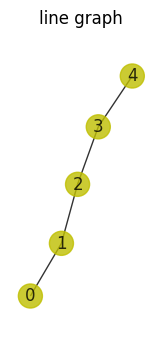

In [299]:
G: nx.Graph = nx.path_graph(5)
_ = show_graph(G, title = "line graph")

Chat GPT code in response to prompt

_Suppose I have created a list of possible partitions created using the Girvan-Newman edge betweenness algorithm._

`all_paritions: list[Tuple[Group, ...]] = list(nx.algorithms.community.centrality.girvan_newman(G))`

_where_ 

`Group = Set[Hashable]`

_Help me write code to create the link matrix so that I can plot the dendrogram using scipy's dendrogram utility_

Look at the set of partitions

In [300]:
from typing import Set
def get_all_partitions(G: nx.Graph) -> list[Tuple[Set[Hashable], ...]]:
    all_partitions:list[Tuple[Set[Hashable], ...]] = [(set(G.nodes()),)]
    all_partitions.extend(list(nx.algorithms.community.centrality.girvan_newman(G)))
    return all_partitions
all_partitions = get_all_partitions(G)
for i, partition in enumerate(all_partitions):
    print(f"partition {i} has sets {partition}")

partition 0 has sets ({0, 1, 2, 3, 4},)
partition 1 has sets ({0, 1}, {2, 3, 4})
partition 2 has sets ({0, 1}, {2}, {3, 4})
partition 3 has sets ({0}, {1}, {2}, {3, 4})
partition 4 has sets ({0}, {1}, {2}, {3}, {4})


I've been pushing chatGPT for a solution that actually works, but it keeps failing. I like the general algorithm they propose though. It uses a merge from bottom up to form the linkage matrix. I'll break the chatGPT solution into pieces to understand where it is failing.

Find the number of leaf nodes and the start creating the clusters at the leaf nodes.

In [301]:
leaves: Tuple[set[Hashable], ...] = all_partitions[-1] # The partition with all the leaves
n = len(leaves)

print(leaves)


({0}, {1}, {2}, {3}, {4})


In [302]:
# In the agglomerative view, the leaves are individual nodes.
# We assign them cluster ids 0, 1, ..., n-1.
clusters: dict[int, frozenset] = {i: frozenset([i]) for i in range(n)}
print(clusters)


{0: frozenset({0}), 1: frozenset({1}), 2: frozenset({2}), 3: frozenset({3}), 4: frozenset({4})}


I asked chatGPT why `frozensets` were used and got this answer.

Frozen sets are used in this code primarily because they are immutable and hashable. This allows them to be used as keys in dictionaries, which is essential when you want to track or map clusters (communities) to specific identifiers.

Here are the key reasons in detail:

1. **Immutability and Hashability:**

- Regular Python sets are mutable, meaning their contents can change. Mutable objects are not hashable, so they cannot be used as keys in dictionaries.
- A frozenset is an immutable version of a set. Once created, its contents cannot be altered, which makes it hashable and safe to use as a dictionary key.

2. **Consistent Representation:**

- Using frozenset ensures that two clusters containing the same nodes will be considered equal regardless of the order of the elements. This consistency is useful when comparing clusters across different partitions.

3. **Tracking Merges:**

- When constructing the linkage matrix or tracking which clusters have merged, you need a way to uniquely and reliably reference each cluster. By converting the sets (which represent communities) into frozensets, you can use them as keys in a dictionary to map them to cluster identifiers or indices.

In summary, frozen sets provide a convenient, reliable, and hashable way to represent clusters of nodes, enabling us to track and compare them efficiently when building the linkage matrix for the dendrogram.

It looks like the chatGPT code reverses the partitions because it makes indexing easier when merges are explored.

In [303]:
# Reverse the partition list so that partitions[0] is the finest (singleton) partition
# and partitions[-1] is the coarsest (first split into 2 communities).
partitions: list[set[int]] = list(all_partitions)
partitions.reverse()
for i, partition in enumerate(partitions):
    print(f"Reversed partition {i} has sets {partition}")

Reversed partition 0 has sets ({0}, {1}, {2}, {3}, {4})
Reversed partition 1 has sets ({0}, {1}, {2}, {3, 4})
Reversed partition 2 has sets ({0, 1}, {2}, {3, 4})
Reversed partition 3 has sets ({0, 1}, {2, 3, 4})
Reversed partition 4 has sets ({0, 1, 2, 3, 4},)


Initialize variables for use in merge.

In [304]:
next_cluster_id: int = n  # new (internal) clusters get ids starting at n.
linkage: list[list[int,int, float, float]] = []

Look at the sets that the chatGPT code deals with in the main loop.

In [305]:
for i in range(len(partitions) - 1):
    fine = partitions[i]      # partition with k communities
    coarse = partitions[i+1]  # partition with k-1 communities
    print(f"level {i}")
    print(f"\tfine = {fine}")
    print(f"\tcoarse = {coarse}")

level 0
	fine = ({0}, {1}, {2}, {3}, {4})
	coarse = ({0}, {1}, {2}, {3, 4})
level 1
	fine = ({0}, {1}, {2}, {3, 4})
	coarse = ({0, 1}, {2}, {3, 4})
level 2
	fine = ({0, 1}, {2}, {3, 4})
	coarse = ({0, 1}, {2, 3, 4})
level 3
	fine = ({0, 1}, {2, 3, 4})
	coarse = ({0, 1, 2, 3, 4},)


Write a function that finds the merge

In [306]:
def find_merge(coarse: list[Tuple[set[Hashable], ...]],
                fine:  list[Tuple[set[Hashable], ...]]
                ) -> Tuple[frozenset, frozenset]:
    for group in coarse:
        # Find all communities in the finer partition that are subsets of this community.
        parts = [c for c in fine if c.issubset(group)]
        # Assumes binary partition used in Girvan Newman
        if len(parts) == 2 and parts[0] | parts[1] == group:
            # These two communities (parts[0] and parts[1]) merged.
            c1, c2 = frozenset(parts[0]), frozenset(parts[1])
            return c1, c2


Explore what this function does

In [307]:
for i in range(len(partitions) - 1):
    fine = partitions[i]      # partition with k communities
    coarse = partitions[i+1]  # partition with k-1 communities
    c1, c2 = find_merge(coarse, fine)
    print(f"level {i}")
    print(f"\tfine = {fine}")
    print(f"\tcoarse = {coarse}")
    print(f"\t\tc1 = {c1}")
    print(f"\t\tc2 = {c2}")

level 0
	fine = ({0}, {1}, {2}, {3}, {4})
	coarse = ({0}, {1}, {2}, {3, 4})
		c1 = frozenset({3})
		c2 = frozenset({4})
level 1
	fine = ({0}, {1}, {2}, {3, 4})
	coarse = ({0, 1}, {2}, {3, 4})
		c1 = frozenset({0})
		c2 = frozenset({1})
level 2
	fine = ({0, 1}, {2}, {3, 4})
	coarse = ({0, 1}, {2, 3, 4})
		c1 = frozenset({2})
		c2 = frozenset({3, 4})
level 3
	fine = ({0, 1}, {2, 3, 4})
	coarse = ({0, 1, 2, 3, 4},)
		c1 = frozenset({0, 1})
		c2 = frozenset({2, 3, 4})


Recall that the `clusters` data structure is a dictionary keyed by a node number with values equal to a frozenset containing the group represented by the node number. The _node number_ in this context is the node in the dendrogram hierarchy, where nodes 0, 1, ... n-1 are the leaf nodes and the other nodes are parts of the tree formed when children nodes are merged.

So, the `find_merge` function looks up the values that would be expected in the `clusters` data structure before the merge is completed.

We now need to find the corresponding index numbers from the `clusters` dictionary since the linkage matrix refers to these index numbers.

In [308]:
def get_ids(c1: frozenset, 
            c2: frozenset, 
            clusters: list[Tuple[set[Hashable], ...]]
            ) -> Tuple[int, int]:
    cid1 = None
    cid2 = None
    for cid, cl in clusters.items():
        if cl == c1:
            cid1 = cid
        if cl == c2:
            cid2 = cid
    return cid1, cid2


Explore what this function does. Right now, it should only work for the `clusters` that form when two leaf nodes are merged. I'll modify that by adding new ids to the `clusters` data structure later.

In [309]:
for i in range(len(partitions) - 1):
    fine = partitions[i]      # partition with k communities
    coarse = partitions[i+1]  # partition with k-1 communities
    c1, c2 = find_merge(coarse, fine)
    cid1, cid2 = get_ids(c1, c2, clusters)
    if cid1 is None or cid2 is None:
        continue
    print(f"level {i}")
    print(f"\tfine = {fine}")
    print(f"\tcoarse = {coarse}")
    print(f"\t\tcluster 1 value = {c1} has index {cid1}")
    print(f"\t\tcluster 2 value = {c2} has index {cid2}")

level 0
	fine = ({0}, {1}, {2}, {3}, {4})
	coarse = ({0}, {1}, {2}, {3, 4})
		cluster 1 value = frozenset({3}) has index 3
		cluster 2 value = frozenset({4}) has index 4
level 1
	fine = ({0}, {1}, {2}, {3, 4})
	coarse = ({0, 1}, {2}, {3, 4})
		cluster 1 value = frozenset({0}) has index 0
		cluster 2 value = frozenset({1}) has index 1


For the sets returned by the Girvan-Newman algorithm, we can assume that each merge creates a new element of `clusters`. So, let's add these new elements to `clusters`.

In [310]:
for i in range(len(partitions) -1 ):
    fine = partitions[i]      # partition with k communities
    coarse = partitions[i+1]  # partition with k-1 communities
    c1, c2 = find_merge(coarse, fine)
    cid1, cid2 = get_ids(c1, c2, clusters)
    if cid1 is None or cid2 is None:
        print(f"Skipping because c1 = {c1} and c2 = {c2} with indices {cid1} and {cid2}")
        continue
    clusters[n] = c1 | c2
    n = n + 1
    print(f"level {i} added cluster {c1 | c2} with index {n}")
    print(f"\tfine = {fine}")
    print(f"\tcoarse = {coarse}")
    print(f"\t\tcluster 1 value = {c1} has index {cid1}")
    print(f"\t\tcluster 2 value = {c2} has index {cid2}")

level 0 added cluster frozenset({3, 4}) with index 6
	fine = ({0}, {1}, {2}, {3}, {4})
	coarse = ({0}, {1}, {2}, {3, 4})
		cluster 1 value = frozenset({3}) has index 3
		cluster 2 value = frozenset({4}) has index 4
level 1 added cluster frozenset({0, 1}) with index 7
	fine = ({0}, {1}, {2}, {3, 4})
	coarse = ({0, 1}, {2}, {3, 4})
		cluster 1 value = frozenset({0}) has index 0
		cluster 2 value = frozenset({1}) has index 1
level 2 added cluster frozenset({2, 3, 4}) with index 8
	fine = ({0, 1}, {2}, {3, 4})
	coarse = ({0, 1}, {2, 3, 4})
		cluster 1 value = frozenset({2}) has index 2
		cluster 2 value = frozenset({3, 4}) has index 5
level 3 added cluster frozenset({0, 1, 2, 3, 4}) with index 9
	fine = ({0, 1}, {2, 3, 4})
	coarse = ({0, 1, 2, 3, 4},)
		cluster 1 value = frozenset({0, 1}) has index 6
		cluster 2 value = frozenset({2, 3, 4}) has index 7


Let's now add information to the linkage matrix

In [ ]:
import numpy as np
import networkx as nx
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from typing import List, Tuple, Set

# Define a type alias for clarity.
Group = Set[Hashable]

def partitions_to_linkage(all_partitions: List[Tuple[Group, ...]]
                          ) -> Tuple[np.ndarray, list[str]]:
    """
    Convert a list of partitions (from Girvan–Newman) into a linkage matrix.
    
    Assumptions:
      • all_partitions is ordered from coarse (few communities) to fine 
        (many communities), with the final partition having each node individually.
      • At each step exactly one community is split into two.
    
    We “invert” the divisive process by processing the partitions in reverse order.
    That is, we start from the finest partition (each node alone) and then
    work backward. In each step we determine which two clusters (from the finer level)
    must have merged to form the cluster at the next coarser level.
    
    We can use the iteration index (plus 1) as the “distance” for the merge,
    or the size of the cluster as the "distance" for the merge.
    The fourth column (the “count”) is taken as the size of the merged cluster.
    
    Returns:
      A linkage matrix Z of shape (n-1, 4) where n is the number of nodes.
    """
    # The final partition gives the leaves.
    leaves: Tuple[Group, ...] = all_partitions[-1]
    n: int = len(leaves)
    labels: list[str] = [str(list(leaf)[0]) for leaf in leaves]
    
    # In the agglomerative view, the leaves are individual nodes.
    # We assign them cluster ids 0, 1, ..., n-1.
    clusters: dict[int, frozenset] = {i: frozenset([i]) for i in range(n)}
    linkage: list[list[int,int, float, float]] = []
    
    # Reverse the partition list so that partitions[0] is the finest (singleton) partition
    # and partitions[-1] is the coarsest (first split into 2 communities).
    partitions: list[Tuple[Group, ...]] = list(all_partitions)
    partitions.reverse()
    
    # Now, for each step (from fine to coarse) we try to determine the merge.
    # (This assumes that each step in the reversed sequence corresponds to one merge.)
    for i in range(len(partitions)-1):
        fine: Tuple[Group, ...] = partitions[i]      # e.g. a partition with k communities
        coarse: Tuple[Group, ...] = partitions[i+1]  # a partition with k-1 communities
        # In the reverse view, one pair of communities in 'fine' must have merged
        # to form a community in 'coarse'. Identify that merge.
        c1, c2 = find_merge(coarse, fine)
        cid1, cid2 = get_ids(c1, c2, clusters)
        if cid1 is None or cid2 is None:
            print(f"Skipping because c1 = {c1} and c2 = {c2} with indices {cid1} and {cid2}")
            continue
        clusters[n] = c1 | c2
        count: int = len(clusters[n])
        n = n + 1
                # Use the step index as the distance (you might choose a different metric)
        #dist = i + 1  
        linkage.append([cid1, cid2, count, count])

    # The linkage list should have (n-1) rows for n leaves.
    Z = np.array(linkage, dtype=np.float64)
    return Z, labels


Look at Z

In [312]:
# Example usage
G: nx.Graph = nx.path_graph(5)
all_partitions = get_all_partitions(G)
Z, labels = partitions_to_linkage(all_partitions)

print(Z)
print(labels)

[[3. 4. 2. 2.]
 [0. 1. 2. 2.]
 [2. 5. 3. 3.]
 [6. 7. 5. 5.]]
['0', '1', '2', '3', '4']


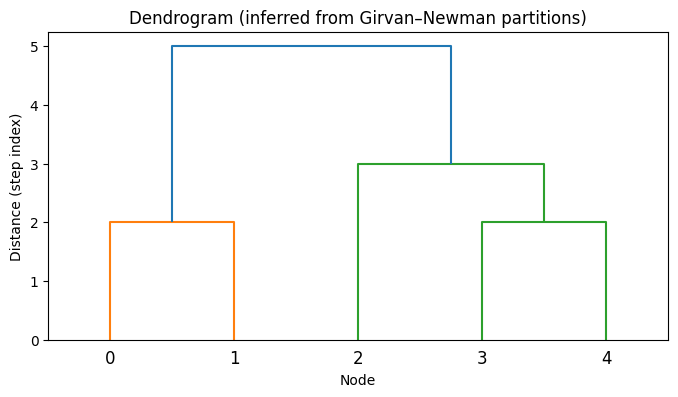

In [313]:
plt.figure(figsize=(8, 4))
dendrogram(Z, labels = labels)
plt.title("Dendrogram (inferred from Girvan–Newman partitions)")
plt.xlabel("Node")
plt.ylabel("Distance (step index)")
plt.show()

Repeat for karate club graph

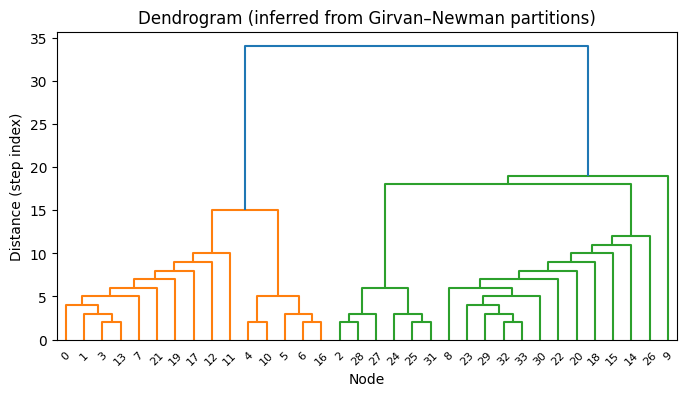

In [314]:
karate_club: nx.Graph = nx.karate_club_graph()
all_partitions = get_all_partitions(karate_club)
Z, labels = partitions_to_linkage(all_partitions)
plt.figure(figsize=(8, 4))
dendrogram(Z, labels = labels)
plt.title("Dendrogram (inferred from Girvan–Newman partitions)")
plt.xlabel("Node")
plt.ylabel("Distance (step index)")
plt.show()

---

For a stochastic block graph

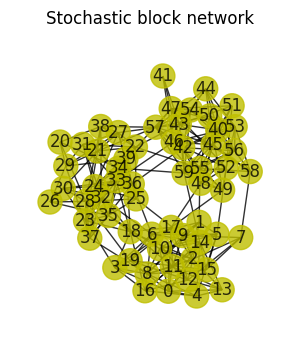

In [315]:
sizes = [20, 20, 20]
probs = [[0.35, 0.02, 0.02], [0.02, 0.35, 0.02], [0.02, 0.02, 0.40]]
stochastic_block: nx. Graph = nx.stochastic_block_model(sizes, probs, seed=42)
_ = show_graph(stochastic_block, title = "Stochastic block network")

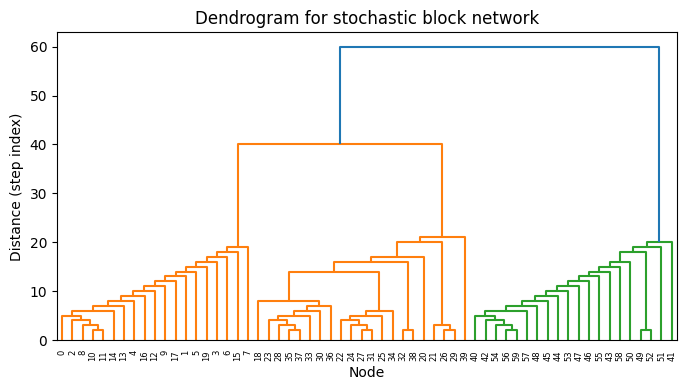

In [316]:
all_partitions = get_all_partitions(stochastic_block)
Z, labels = partitions_to_linkage(all_partitions)
plt.figure(figsize=(8, 4))
dendrogram(Z, labels = labels)
plt.title("Dendrogram for stochastic block network")
plt.xlabel("Node")
plt.ylabel("Distance (step index)")
plt.show()

---

For small-world network

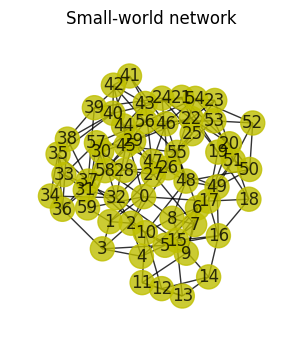

In [319]:
small_world = nx.newman_watts_strogatz_graph(60, 4, 0.3, seed = 42)
_ = show_graph(small_world, 
               title = "Small-world network")

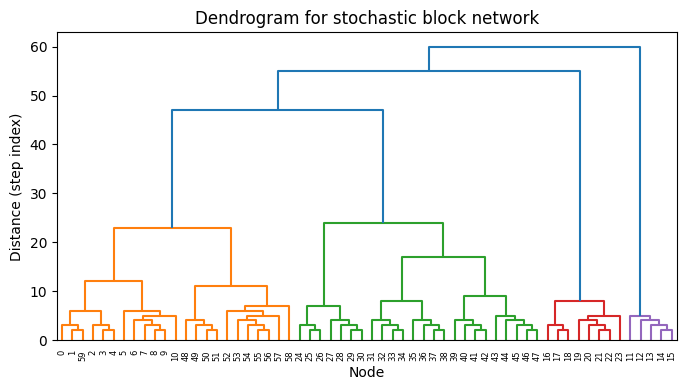

In [ ]:
all_partitions = get_all_partitions(small_world)
Z, labels = partitions_to_linkage(all_partitions)
plt.figure(figsize=(8, 4))
dendrogram(Z, labels = labels)
plt.title("Dendrogram for small-world network")
plt.xlabel("Node")
plt.ylabel("Distance (step index)")
plt.show()